# 04: Benchmark LLM Quantization Methods

## 1. Imports

In [1]:
import gc
import copy
# import os
# CACHE_PATH = '<path_to_cache>'
# os.environ["TORCH_HOME"] = CACHE_PATH
# os.environ["HF_HOME"] = CACHE_PATH
# os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_PATH
# os.environ["HUGGINGFACE_ASSETS_CACHE"] = CACHE_PATH
# os.environ["TRANSFORMERS_CACHE"] = CACHE_PATH

import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
# from huggingface_hub import login; login(token="<hf_token>")

import pruna_pro
from pruna_pro import SmashConfig
from pruna_pro import smash
from pruna.data.pruna_datamodule import PrunaDataModule
from pruna.evaluation.evaluation_agent import EvaluationAgent
from pruna.evaluation.metrics.metric_elapsed_time import ElapsedTimeMetric
from pruna.evaluation.metrics.metric_torch import TorchMetricWrapper
from pruna.evaluation.metrics.metric_energy import EnergyMetric
from pruna.evaluation.metrics.metric_memory import GPUMemoryMetric
from pruna.evaluation.metrics.metric_model_architecture import ModelArchitectureMetric
from pruna.evaluation.task import Task

## 2. Utils

The utils functions help for:
- Load from a list of (small) models.  eel free to try other models until the GPU memory is not enough!
- Make plots.
- Iterate over evaluation and model configurations.

In [2]:
model_ids = [
    # "facebook/opt-125m",
    # "facebook/opt-350m", 
    # "facebook/opt-1.3b",
    # "facebook/opt-2.7b",
    # "meta-llama/Llama-3.2-1B",
    # "meta-llama/Llama-3.2-1B-Instruct",
    # "meta-llama/Llama-3.2-3B-Instruct",
    # "google/gemma-3-1b-it",
    # "google/gemma-3-4b-it",
    # "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    # "microsoft/Phi-4-mini-instruct",
    # "HuggingFaceTB/SmolLM-135M",
    # "HuggingFaceTB/SmolLM-135M-instruct",
    # "HuggingFaceTB/SmolLM-360M", 
    # "HuggingFaceTB/SmolLM-360M-Instruct",
    # "HuggingFaceTB/SmolLM-1.7B",
    # "HuggingFaceTB/SmolLM-1.7B-Instruct",
    # "HuggingFaceTB/SmolLM2-135M",
    # "HuggingFaceTB/SmolLM2-135M-Instruct",
    # "HuggingFaceTB/SmolLM2-360M",
    # "HuggingFaceTB/SmolLM2-360M-Instruct", 
    # "HuggingFaceTB/SmolLM2-1.7B",
    # "HuggingFaceTB/SmolLM2-1.7B-Instruct",
    "PleIAs/Pleias-350m-Preview",
    # "PleIAs/Pleias-Pico",
    # "PleIAs/Pleias-1.2b-Preview",
    # "PleIAs/Pleias-Nano",
    # "PleIAs/Pleias-3b-Preview",
]

# Load model and tokenizer for first model in list
model_id = model_ids[0]
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [3]:
def evaluate_model(model, tokenizer, dataset="WikiText"):
    """Evaluate a language model using multiple metrics.

    Args:
        model: The language model to evaluate (AutoModelForCausalLM)
        tokenizer: The tokenizer associated with the model (AutoTokenizer) 
        dataset: Name of the dataset to evaluate on (default: "WikiText")

    Returns:
        dict: Dictionary containing evaluation results with metrics like:
            - Elapsed time (inference speed)
            - GPU memory usage
            - Energy consumption
            - Model architecture details
            - Perplexity score
    """
    metrics = [
        ElapsedTimeMetric(n_iterations = 100,
                          n_warmup_iterations = 10,
                          device = "cuda",
                          timing_type = "sync",),
        GPUMemoryMetric(mode = "disk"),
        EnergyMetric(n_iterations = 100,
                n_warmup_iterations = 10,
                device = "cuda"),
        ModelArchitectureMetric(),
        TorchMetricWrapper(metric_name="perplexity", call_type="y_gt")
            ]

    task = Task(metrics, datamodule=PrunaDataModule.from_string(dataset, tokenizer=tokenizer))
    eval_agent = EvaluationAgent(task)

    # Run evaluation
    return eval_agent.evaluate(model)

## 3. Benchmark LLM Quantization Methods

We recommend to checkout the [Pruna documentation](https://docs.pruna.ai/en/stable/docs_pruna/user_manual/evaluation.html) for access to AI efficiency functions.

### 3.1 Define quantization configurations

**Implementation task:**
- Define LLM.int8(), GPTQ, HQQ, AWQ, Quanto quantization configurations for 4 bits quantization.
- Benchmark the base models on GPU with respect to the latency metrics.

**Questions:**
- Which method uses linear/codebook quantization?
- Which method quantizes the weights/activations?

In [4]:
# Create list of SmashConfig with different quantization methods
smash_configs = []

### To Complete ###
# LLM INT8
config_llm_int8 = SmashConfig()
config_llm_int8.add_tokenizer(model_id)
config_llm_int8['quantizer'] = 'llm_int8'
config_llm_int8['llm_int8_weight_bits'] = 4
smash_configs.append(config_llm_int8)

# GPTQ
config_gptq = SmashConfig()
config_gptq.add_tokenizer(model_id)
config_gptq.add_data("WikiText")
config_gptq['quantizer'] = 'gptq'
config_gptq['gptq_weight_bits'] = 4
smash_configs.append(config_gptq)

# HQQ
config_hqq = SmashConfig()
config_hqq.add_tokenizer(model_id)
config_hqq['quantizer'] = 'hqq'
config_hqq['hqq_weight_bits'] = 4
smash_configs.append(config_hqq)

# AWQ
config_awq = SmashConfig()
config_awq.add_tokenizer(model_id)
config_awq.add_data("WikiText")
config_awq['quantizer'] = 'awq'
config_awq['awq_weight_bits'] = 4
smash_configs.append(config_awq)

# Quanto
config_quanto = SmashConfig()
config_quanto.add_tokenizer(model_id)
config_quanto['quantizer'] = 'quanto'
config_quanto['quanto_weight_bits'] = "qint4"
smash_configs.append(config_quanto)
### End of To Complete ###

INFO - Using max_seq_len of tokenizer: None
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7f0f9f8ea440>, tokenizer=PreTrainedTokenizerFast(name_or_path='PleIAs/Pleias-350m-Preview', vocab_size=65536, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|end_of_text|>', 'eos_token': '<|end_of_text|>', 'unk_token': '[UNK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), max_seq_len=None)...
Asking to truncate 

### 3.2 Evaluate quantization configurations

**Implementation task:**
- Apply all the quantization configurations on the base model.
- Evaluate all the quantization configurations on GPU by using the `evaluate_model` function.

**Questions:**
- Which method uses the least amount of memory?
- Which method is the fastest?
- Which method has the best energy efficiency?
- Which method has the best perplexity?

In [5]:
def evaluate_configs(model, smash_configs, dataset="WikiText"):
    """Evaluate multiple quantization configurations on a model.

    Args:
        model: The base model to quantize and evaluate
        smash_configs: List of SmashConfig objects containing quantization settings
        dataset: Name of dataset to evaluate on (default: "WikiText")

    Returns:
        dict: Results dictionary mapping quantizer names to evaluation metrics
    """
    results = {}
    
    ### To Complete ###
    for config in smash_configs:
        # Deep copy the model for this config
        model_copy = copy.deepcopy(model)
        
        try:
            # Apply quantization
            quantized_model = smash(model_copy, config)
            
            # Evaluate
            result = evaluate_model(quantized_model, tokenizer, dataset)
            results[config['quantizer']] = result
            
        except Exception as e:
            print(f"Error evaluating {config['quantizer']}: {str(e)}")
            results[config['quantizer']] = None

        finally:
            # Clean up
            del model_copy
            try:
                del quantized_model
            except:
                pass
            torch.cuda.empty_cache()
            gc.collect()
    ### End of To Complete ###
    
    return results

In [6]:
evaluation_results = evaluate_configs(model, smash_configs)

INFO - Verifying Pruna token.
INFO - You have used 128 hours this month.
INFO - Starting quantizer llm_int8...
`low_cpu_mem_usage` was None, now default to True since model is quantized.
INFO - quantizer llm_int8 was applied successfully.
INFO - You have used 128 hours this month.
INFO - Using call_type: y_gt for metric perplexity
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7ff7e6942c20>, tokenizer=PreTrainedTokenizerFast(name_or_path='PleIAs/Pleias-350m-Preview', vocab_size=65536, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|end_of_text|>', 'eos_token': '<|end_of_text|>', 'unk_token': '[UNK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normali

Quantizing model.layers blocks :   0%|          | 0/26 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
INFO - quantizer gptq was applied successfully.
INFO - You have used 129 hours this month.
INFO - Using call_type: y_gt for metric perplexity
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7ff7e6942c20>, tokenizer=PreTrainedTokenizerFast(name_or_path='PleIAs/Pleias-350m-Preview', vocab_size=65536, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|end_of_text|>', 'eos_token': '<|end_of_text|>', 'unk_token': '[UNK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False

Error evaluating awq: LlamaAttention.forward() missing 1 required positional argument: 'attention_mask'


INFO - Verifying Pruna token.
INFO - You have used 129 hours this month.
INFO - Starting quantizer quanto...
ERROR - Calibration requires a tokenizer and dataloader. Skipping calibration.
INFO - quantizer quanto was applied successfully.
INFO - You have used 129 hours this month.
INFO - Using call_type: y_gt for metric perplexity
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7ff7e6942c20>, tokenizer=PreTrainedTokenizerFast(name_or_path='PleIAs/Pleias-350m-Preview', vocab_size=65536, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|end_of_text|>', 'eos_token': '<|end_of_text|>', 'unk_token': '[UNK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normaliz

Error evaluating torch_static: Embedding quantization is only supported with float_qparams_weight_only_qconfig.


INFO - Verifying Pruna token.
INFO - You have used 130 hours this month.
INFO - Starting quantizer torch_dynamic...
INFO - quantizer torch_dynamic was applied successfully.
INFO - You have used 130 hours this month.
INFO - Using call_type: y_gt for metric perplexity
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7ff7e6942c20>, tokenizer=PreTrainedTokenizerFast(name_or_path='PleIAs/Pleias-350m-Preview', vocab_size=65536, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|end_of_text|>', 'eos_token': '<|end_of_text|>', 'unk_token': '[UNK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<|end_of_text|>", rstrip

Error evaluating torch_dynamic: Could not run 'quantized::linear_dynamic' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_dynamic' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at ../aten/src/ATen/native/qu

### 3.3 Compare quantized LLMs on a pareto front

**Implementation task:**
- Plot the results of the previous metrics in a pareto front. You can use the files containing the saved results when evaluating the previous metrics.

**Questions:**
- What is the best quantizedmodel on the pareto front?

In [7]:
def plot_pareto_front(results, metric1_name, metric2_name):
    """
    Plot a pareto front comparing two metrics across different quantization methods.

    Args:
        results (dict): Dictionary mapping quantizer names to their evaluation results
        metric1_name (str): Name of the first metric to plot on x-axis
        metric2_name (str): Name of the second metric to plot on y-axis

    Creates a scatter plot showing the tradeoff between the two metrics for each quantizer,
    with points labeled by quantizer name. Includes a grid and appropriate axis labels.
    """
    # Extract metrics for each quantizer
    quantizers = []
    metric1_values = []
    metric2_values = []
    
    for quantizer, result in results.items():
        if result is not None and metric1_name in result and metric2_name in result:
            quantizers.append(quantizer)
            metric1_values.append(result[metric1_name])
            metric2_values.append(result[metric2_name])
    
    plt.figure(figsize=(10, 6))
    plt.scatter(metric1_values, metric2_values)
    for i, quantizer in enumerate(quantizers):
        plt.annotate(quantizer, (metric1_values[i], metric2_values[i]), 
                    xytext=(5, 5), textcoords='offset points')
    plt.xlabel(metric1_name)
    plt.ylabel(metric2_name)
    plt.title(f'Pareto Front: {metric1_name} vs {metric2_name}')    
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()

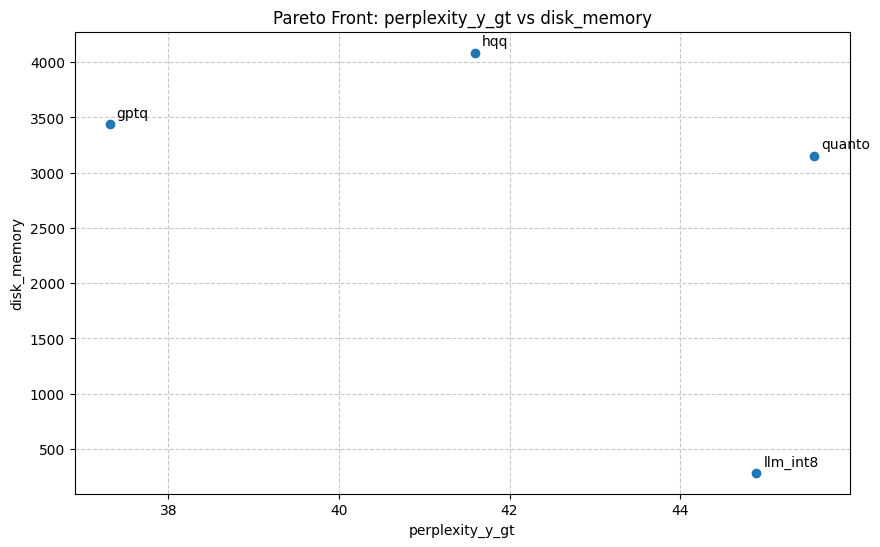

In [11]:
plot_pareto_front(evaluation_results, 'perplexity_y_gt', 'disk_memory')

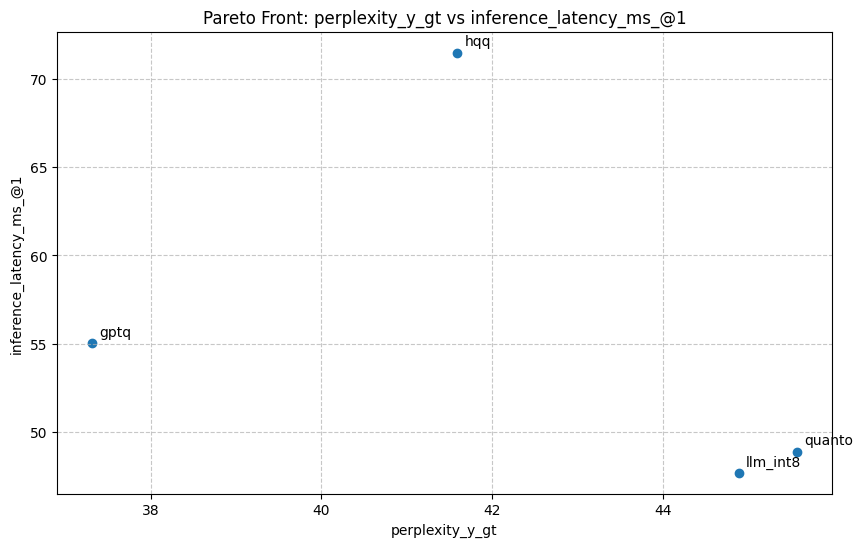

In [10]:
plot_pareto_front(evaluation_results, 'perplexity_y_gt', 'inference_latency_ms_@1')